In [1]:
import os
import sys
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tensorflow as tf
print(tf.__version__)
try:
    import keras
except:
    import tensorflow.keras as keras
print(keras.__version__)

from keras.layers import Input, Dense, Conv1D, Conv2D, MaxPool1D, LSTM, Lambda, Concatenate, Reshape, Permute, Multiply, Add, Softmax, ReLU, Dropout, Flatten, Dot  

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

1.14.0
2.2.4


Using TensorFlow backend.


In [7]:
def Preprocessing(auction, dataset_name, y_type, normalization_type, split_type):
    n_ticks=np.load(auction+'_n_ticks.npy')-105
    x = np.load(auction+'_'+dataset_name+'_'+normalization_type+'_x.npy')
    y = np.load(auction+'_'+dataset_name+'_'+normalization_type+'_y.npy')
    break_points=[0]+list(n_ticks.flatten().cumsum())
    x = np.array([x[break_points[i]:break_points[i+1]] for i in range(len(break_points)-1)]).reshape(10,5)
    # print(n_ticks)
    # print(np.array([len(x[day, stock]) for day in range(10) for stock in range(5)]).reshape(10,5))

    columns = ['price', 'time', 'volume_new', 'volume_old', 'level_new', 'level_old', 
               'pa1_new', 'pa1_old', 'va1_new', 'va1_old', 'pb1_new', 'pb1_old', 'vb1_new', 'vb1_old', 'side']
    y_type_dict={'y1':0, 'y2':1, 'y5':2, 'y1true':3, 'y2true':4, 'y5true':5}
    
    y = y[:, y_type_dict[y_type]*3:y_type_dict[y_type]*3+3]
    
    idx = [2, 3, 8, 9, 12, 13]
    for day in range(10):
        for stock in range(5):
            x[day,stock][:,:,idx] /= 800
            if stock in [1, 2, 3]:
                x[day,stock][:,:,idx] /= 5
    x = np.concatenate(x.flatten())
    idx = [0, 1, 6, 7, 10, 11]
    x[:,:,idx] /= 10
    x[:,:,1] += 2
    idx = [4, 5]
    x[:,:,idx] -= 5
    x[:,:,idx] /= 2

    if split_type=='default':
        break_points = [0, np.sum(n_ticks[:5]), np.sum(n_ticks[:7]), np.sum(n_ticks)]
        data={'train_x':x[break_points[0]:break_points[1]], 'train_y':y[break_points[0]:break_points[1]],
              'val_x':  x[break_points[1]:break_points[2]], 'val_y':  y[break_points[1]:break_points[2]],
              'test_x': x[break_points[2]:break_points[3]], 'test_y': y[break_points[2]:break_points[3]]}

    for key in data.keys():
        print(key, data[key].shape)
    return data


In [8]:
# leaky_relu = keras.activations.relu(x, alpha=0.01, max_value=None, threshold=0.0)

def Scaled_Dot_Product_Self_Attention(x, n_filters=16):
    x1 = Conv1D(filters=n_filters, kernel_size=1, activation='relu')(x)
    x2 = Conv1D(filters=n_filters, kernel_size=1, activation='relu')(x)
    x3 = Conv1D(filters=n_filters, kernel_size=1, activation='relu')(x)
    x4 = Dot(axes=2)([x1,x2])
    x4 = Lambda(lambda x: x/keras.backend.sqrt(keras.backend.cast(n_filters, 'float32')))(x4)
    x4 = Softmax(axis=1)(x4)
    x5 = Dot(axes=1)([x4,x3])
    return x5

def Multi_Head_Self_Attention(x, n_filters=16, n_heads=8):
    x1 = [Scaled_Dot_Product_Self_Attention(x, n_filters=n_filters) for i in range(n_heads)]
    x = Concatenate(axis=-1)(x1)
    print(x.shape)
    return x

def Linear_Feature_Transformation(x, n_filters=64):
    x = Conv1D(filters=n_filters, kernel_size=1, activation='relu')(x)
    print(x.shape)
    x = Conv1D(filters=n_filters, kernel_size=1, activation='relu')(x)
    print(x.shape)
    return x

def Prediction_Module(x, n_filters=16):
    x = Lambda(lambda x: x[:,-2:])(x)
    print(x.shape)
    x = Flatten()(x)
    x = Dense(n_filters, activation='relu')(x)
    print(x.shape)
    x = Dense(3, activation='softmax')(x)
    print(x.shape)
    return x


def MHSA1(x):
    x = Linear_Feature_Transformation(x)
    x = Multi_Head_Self_Attention(x)
    x = Prediction_Module(x)
    return x

def MHSA2(x):
    x = Linear_Feature_Transformation(x, n_filters=32)
    x = Multi_Head_Self_Attention(x, n_filters=8)
    x = Linear_Feature_Transformation(x, n_filters=32)
    x = Multi_Head_Self_Attention(x, n_filters=8)
    x = Linear_Feature_Transformation(x, n_filters=32)
    x = Multi_Head_Self_Attention(x, n_filters=8)
    x = Linear_Feature_Transformation(x, n_filters=32)
    x = Multi_Head_Self_Attention(x, n_filters=8)
    x = Prediction_Module(x)
    return x

def LSTM1(x):
    x = Linear_Feature_Transformation(x)
    x = LSTM(units=64, return_sequences=True, implementation=2, unroll=True)(x)
    print(x.shape)
    x = Prediction_Module(x)
    return x

def LSTM2(x):
    x = Linear_Feature_Transformation(x, n_filters=32)
    x = LSTM(units=32, return_sequences=True, implementation=2, unroll=True)(x)
    print(x.shape)
    x = Linear_Feature_Transformation(x, n_filters=32)
    x = LSTM(units=32, return_sequences=True, implementation=2, unroll=True)(x)
    print(x.shape)
    x = Linear_Feature_Transformation(x, n_filters=32)
    x = LSTM(units=32, return_sequences=True, implementation=2, unroll=True)(x)
    print(x.shape)
    x = Linear_Feature_Transformation(x, n_filters=32)
    x = LSTM(units=32, return_sequences=True, implementation=2, unroll=True)(x)
    print(x.shape)
    x = Prediction_Module(x)
    return x

In [9]:
data = Preprocessing('NoAuction', 'DecPre', 'y1true', 'order', 'default')

train_x (175627, 200, 15)
train_y (175627, 3)
val_x (75448, 200, 15)
val_y (75448, 3)
test_x (138012, 200, 15)
test_y (138012, 3)


In [13]:
model_name = 'MHSA1'
train_x=data['train_x']
models_list={'MHSA1':MHSA1, 'MHSA2':MHSA2, 'LSTM1':LSTM1, 'LSTM2':LSTM2}  # 34307, 38435, 40323, 42,275
inputs = Input(shape=train_x.shape[1:])
outputs = models_list[model_name](inputs)
model = keras.models.Model(inputs=inputs, outputs=outputs)
print(model.summary())

(?, 200, 64)
(?, 200, 64)
(?, 200, 128)
(?, 2, 128)
(?, 16)
(?, 3)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 200, 15)      0                                            
__________________________________________________________________________________________________
conv1d_116 (Conv1D)             (None, 200, 64)      1024        input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_117 (Conv1D)             (None, 200, 64)      4160        conv1d_116[0][0]                 
__________________________________________________________________________________________________
conv1d_118 (Conv1D)             (None, 200, 16)      1040        conv1d_117[0][0]                 
__________________________________________

In [4]:
def GPU_setup(gpu_number, thread_number, allow_growth=True, allow_soft_placement=True):
    tf.reset_default_graph()
    keras.backend.clear_session()

    tf_config = tf.ConfigProto(allow_soft_placement=allow_soft_placement)
    tf_config.gpu_options.visible_device_list = str(gpu_number)
    tf_config.gpu_options.per_process_gpu_memory_fraction = 1/thread_number
    tf_config.gpu_options.allow_growth = allow_growth
    keras.backend.set_session(tf.Session(config=tf_config) )
    
def Train_model(train_x, train_y, val_x, val_y, model_name, lr, batch_size, output_folder, class_weight):
    models_list={'MHSA1':MHSA1, 'MHSA2':MHSA2, 'LSTM1':LSTM1, 'LSTM2':LSTM2}
    start=time.time()
    inputs = Input(shape=train_x.shape[1:])
    outputs = models_list[model_name](inputs)
    model = keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], 
                  optimizer=keras.optimizers.Adam(lr=lr))

    earlystopping = keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', min_delta=0, patience=10, 
                                                  verbose=1, mode='auto', baseline=None, restore_best_weights=True)
    csvlogger = keras.callbacks.CSVLogger(output_folder+'history.csv', separator=',', append=False)
    history = model.fit(train_x, train_y, validation_data=(val_x, val_y), batch_size=batch_size, epochs=200, 
                        shuffle=True, verbose=1, callbacks=[earlystopping, csvlogger], class_weight=class_weight) 
    
    model.save(output_folder+'model.hdf5')   
    
    training_time = int((time.time()-start)/60)
    print('training time used:', training_time//60, ':' , training_time%60)
    
    return model, history.history, training_time

def Plot_training_curve(history):
    _, axes=plt.subplots(1,2,figsize=(20,5))
    for i, metric in enumerate(['loss', 'categorical_accuracy']):
        for split in ['', 'val_']:
            _=axes[i].plot(history[split+metric], label=split+metric)
        _=axes[i].legend()
    plt.show()

def Get_test_results(model, test_x, test_y):
    predict_test_y=np.eye(test_y.shape[1])[np.argmax(model.predict(test_x, batch_size=2048, verbose=1), axis=1)]
    results = {'accuracy ': accuracy_score(test_y, predict_test_y)}
    results.update(zip(['precision', 'recall', 'f1_score'], precision_recall_fscore_support(test_y, predict_test_y, average='weighted')[:3]))

    print('\n'.join([item[0]+' '.join(['' for i in range(12-len(item[0]))])+str(item[1]) for item in results.items()]))
    print(confusion_matrix(np.argmax(test_y, axis=1), np.argmax(predict_test_y, axis=1)))
    print(precision_recall_fscore_support(test_y, predict_test_y, average=None))
    return results

def Save_information(preprocessing_parameters, training_parameters, results, training_time, history, output_folder):
    information={**preprocessing_parameters, **training_parameters, **results}
    information['training_time']=training_time
    information['epochs_trained']=len(history['loss'])
    information=json.dumps(information, separators=('\n ', ': '), sort_keys=False)
    print(information)
    with open(output_folder+'information.json', 'w') as f:
        f.write(information)
        
def Load_model(output_folder):
    model = keras.models.load_model(output_folder+'model.hdf5', custom_objects={'keras': keras})
    return model

def Load_information(output_folder):
    information=json.loads(open(output_folder+'information.json', 'r').read().replace('\n ', ', '))
    print(json.dumps(information, separators=('\n ', ': '), sort_keys=False))
    return information


W0901 18:42:01.205822 140045142873920 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0901 18:42:01.206666 140045142873920 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0901 18:42:01.224326 140045142873920 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0901 18:42:01.400379 140045142873920 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-pac

train_x (175627, 200, 15)
train_y (175627, 3)
val_x (75448, 200, 15)
val_y (75448, 3)
test_x (138012, 200, 15)
test_y (138012, 3)
(?, 200, 32)
(?, 200, 32)
(?, 200, 64)
(?, 200, 32)
(?, 200, 32)
(?, 200, 64)
(?, 200, 32)
(?, 200, 32)
(?, 200, 64)
(?, 200, 32)
(?, 200, 32)


W0901 18:42:03.929770 140045142873920 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



(?, 200, 64)
(?, 2, 64)
(?, 16)
(?, 3)


W0901 18:42:04.180190 140045142873920 deprecation.py:323] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 175627 samples, validate on 75448 samples
Epoch 1/200
175627/175627 [==============================] - 134s 764us/step - loss: 2.6333 - categorical_accuracy: 0.3430 - val_loss: 1.2356 - val_categorical_accuracy: 0.2372
Epoch 2/200
175627/175627 [==============================] - 115s 654us/step - loss: 2.5291 - categorical_accuracy: 0.3167 - val_loss: 1.1118 - val_categorical_accuracy: 0.2980
Epoch 3/200
175627/175627 [==============================] - 115s 654us/step - loss: 2.4555 - categorical_accuracy: 0.3254 - val_loss: 1.1015 - val_categorical_accuracy: 0.2967
Epoch 4/200
175627/175627 [==============================] - 115s 654us/step - loss: 2.4370 - categorical_accuracy: 0.3330 - val_loss: 1.0445 - val_categorical_accuracy: 0.3265
Epoch 5/200
175627/175627 [==============================] - 115s 653us/step - loss: 2.4243 - categorical_accuracy: 0.3392 - val_loss: 1.0323 - val_categorical_accuracy: 0.3652
Epoch 6/200
175627/175627 [==============================] - 115

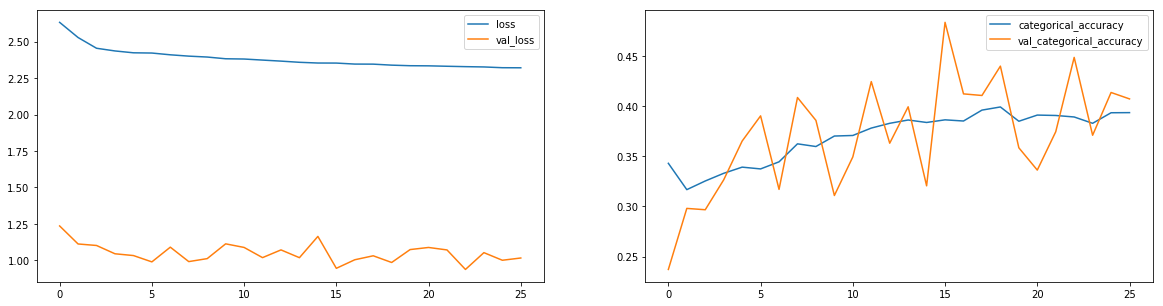

138012/138012 [==============================] - 21s 149us/step
accuracy   0.5780946584354983
precision  0.7781492453853682
recall     0.5780946584354983
f1_score   0.6385108403763391
[[ 7544  3315  1951]
 [29809 66881 16475]
 [ 2875  3803  5359]]
(array([0.18753107, 0.90380951, 0.22531007]), array([0.58891491, 0.59100429, 0.4452106 ]), array([0.28447528, 0.71467804, 0.29920161]), array([ 12810, 113165,  12037]))
{"auction": "NoAuction"
 "dataset_name": "DecPre"
 "y_type": "y1true"
 "normalization_type": "order"
 "split_type": "default"
 "model_name": "MHSA2"
 "lr": 0.001
 "batch_size": 256
 "accuracy ": 0.5780946584354983
 "precision": 0.7781492453853682
 "recall": 0.5780946584354983
 "f1_score": 0.6385108403763391
 "training_time": 50
 "epochs_trained": 26}
train_x (175627, 200, 15)
train_y (175627, 3)
val_x (75448, 200, 15)
val_y (75448, 3)
test_x (138012, 200, 15)
test_y (138012, 3)
(?, 200, 32)
(?, 200, 32)
(?, 200, 64)
(?, 200, 32)
(?, 200, 32)
(?, 200, 64)
(?, 200, 32)
(?, 200, 

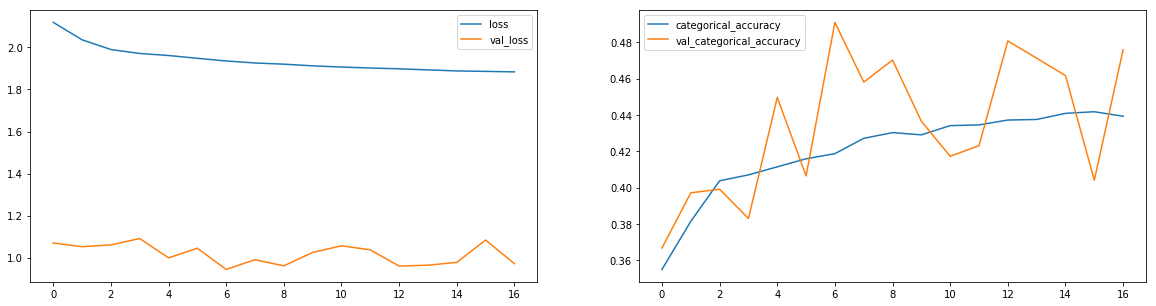

138012/138012 [==============================] - 21s 149us/step
accuracy   0.5564226299162391
precision  0.6714224236296262
recall     0.5564226299162391
f1_score   0.5890063146570166
[[12155  5503  3650]
 [25834 55877 15181]
 [ 5056  5995  8761]]
(array([0.28237891, 0.82934323, 0.31751957]), array([0.57044303, 0.57669364, 0.44220674]), array([0.37776017, 0.68031924, 0.36963125]), array([21308, 96892, 19812]))
{"auction": "NoAuction"
 "dataset_name": "DecPre"
 "y_type": "y2true"
 "normalization_type": "order"
 "split_type": "default"
 "model_name": "MHSA2"
 "lr": 0.001
 "batch_size": 256
 "accuracy ": 0.5564226299162391
 "precision": 0.6714224236296262
 "recall": 0.5564226299162391
 "f1_score": 0.5890063146570166
 "training_time": 33
 "epochs_trained": 17}
train_x (175627, 200, 15)
train_y (175627, 3)
val_x (75448, 200, 15)
val_y (75448, 3)
test_x (138012, 200, 15)
test_y (138012, 3)
(?, 200, 32)
(?, 200, 32)
(?, 200, 64)
(?, 200, 32)
(?, 200, 32)
(?, 200, 64)
(?, 200, 32)
(?, 200, 32)

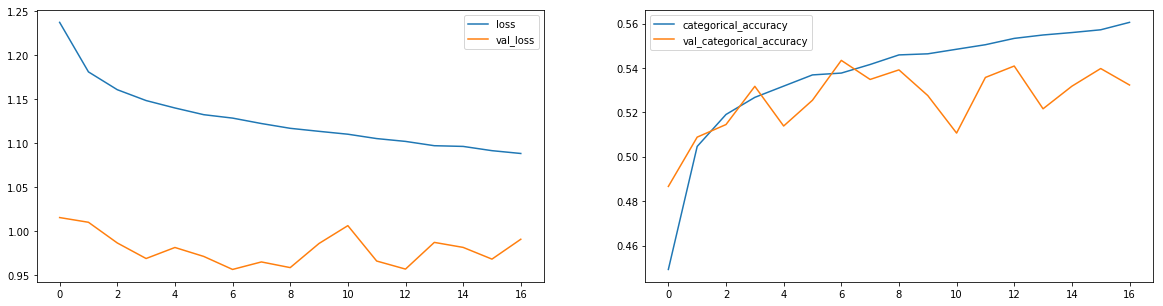

138012/138012 [==============================] - 21s 150us/step
accuracy   0.556553053357679
precision  0.5718158646708652
recall     0.556553053357679
f1_score   0.5616588070226501
[[19524  9271  7620]
 [15285 41441 11431]
 [ 8715  8879 15846]]
(array([0.44858009, 0.69542381, 0.45407915]), array([0.53615268, 0.60802265, 0.47386364]), array([0.48847246, 0.64879294, 0.46376048]), array([36415, 68157, 33440]))
{"auction": "NoAuction"
 "dataset_name": "DecPre"
 "y_type": "y5true"
 "normalization_type": "order"
 "split_type": "default"
 "model_name": "MHSA2"
 "lr": 0.001
 "batch_size": 256
 "accuracy ": 0.556553053357679
 "precision": 0.5718158646708652
 "recall": 0.556553053357679
 "f1_score": 0.5616588070226501
 "training_time": 33
 "epochs_trained": 17}


In [ ]:
for y_type in ['y1true', 'y2true', 'y5true']:
    
    preprocessing_parameters={'auction':'NoAuction', 'dataset_name':'DecPre', 'y_type':y_type,
                              'normalization_type':'order', 'split_type':'default'}
    data = Preprocessing(**preprocessing_parameters)
    
    for batch_size, lr in [(256, 0.001)]:
        model_name = 'MHSA2'
        output_folder=os.getcwd()+'/output_'+'_'.join(['weighted', y_type, model_name, str(batch_size), str(lr)])+'/'
        training_parameters={'model_name': model_name, 'lr': lr, 'batch_size': batch_size}
        gpu_parameters={'gpu_number':0, 'thread_number':1}
        
        weighted = True
        class_weight=None
        if weighted==True:
            if y_type=='y1true':
                class_weight={0:7.0, 1:1.0, 2:7.0}
            elif y_type=='y2true':
                class_weight={0:3.5, 1:1.0, 2:3.5}
            elif y_type=='y5true':
                class_weight={0:1.3, 1:1.0, 2:1.3}
        
        try:
            os.mkdir(output_folder)
            GPU_setup(**gpu_parameters)
            model, history, training_time = Train_model(*tuple(data.values())[:4], **training_parameters, 
                                                        output_folder=output_folder, class_weight=class_weight)
            Plot_training_curve(history)
            results = Get_test_results(model, *tuple(data.values())[-2:])
            Save_information(preprocessing_parameters, training_parameters, results, 
                             training_time, history, output_folder)
        except:
            pass

In [ ]:
table_entry=[]
for experiment in list(sorted([i for i in os.listdir() if 'output' in i])):
    table_entry.append([experiment.replace('output_', '').replace('_', ', ')])
    information=json.loads(open(experiment+'/'+'information.json', 'r').read().replace('\n ', ', ')) 
    for key in ['accuracy ','precision','recall','f1_score']:
        table_entry[-1].append(str(round(information[key]*100, 2)))
        table_entry[-1][-1]+=''.join(['0' for i in range(5-len(table_entry[-1][-1]))])
    for key in ['training_time']:
        table_entry[-1].append(str(information[key]))

results=(' \\\\ \n').join([' & '.join(table_entry[i]) for i in range(len(table_entry))])
results = '\\begin{table}[!ht] \n \centering \n \\begin{tabular}{l|c c c c c } \n \hline \n'+ \
' & '.join(['Experiment', 'Accuracy \%', 'Precision \%', 'Recall \%', 'F1 \%', 'Training Time (min)'])+ \
' \\\\ \\hline\n'+results+' \\\\ \\hline\n \end{tabular} \n \caption{} \n \label{} \n\end{table}'

print(results)

In [ ]:
# history=pd.read_csv(output_folder+'history.csv')
# Plot_training_curve(history)
# information = Load_information(output_folder)
# model = Load_model(output_folder)
# results = Get_test_results(model, *tuple(data.values())[-2:])